In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import OrderedDict
import sys
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from skyfield.api import Topos, load, EarthSatellite
import spacetracktool as st
from spacetracktool import operations as ops
from os import path
import json
from tqdm import tqdm
query = st.SpaceTrackClient("steverajprabu@gmail.com", "Qwertyuiop1234567890")
ts = load.timescale(builtin=True)
mwa = Topos("26.701276778 S", "116.670846137 E", elevation_m= 377.827)
import csv
import time

In [18]:
def TLE_query(UTC, norad, obs):
    query = st.SpaceTrackClient('steverajprabu@gmail.com', 'Qwertyuiop1234567890')
    start_date = UTC + timedelta(hours=-24*2)
    end_date = UTC + timedelta(hours=24*2)
    date_range = ops.make_range_string(str(start_date.year) + "-" + str(start_date.month).zfill(2) + "-"+ str(start_date.day).zfill(2),
       str(end_date.year) + "-" + str(end_date.month).zfill(2) + "-"+ str(end_date.day).zfill(2))
    
    result = query.tle_query(epoch=date_range, norad_cat_id=norad)
   
    
    return result.json()[0]["TLE_LINE1"], result.json()[0]["TLE_LINE2"]


    

def getRCS(norad):
    f = open("/media/steve/NewSSD/SpaceFest/RCS.txt")
    rline =  f.readline()
    local_RCS = 0
    while rline:
        local_ID =int( rline[13] + rline[14] + rline[15] + rline[16] + rline[17])
        if norad == local_ID:
            local_RCS = str(rline[119] + rline[120] + rline[121] + rline[122] + rline[123] + rline[124] + rline[125] + rline[126])
            local_RCS = local_RCS.replace(" ", "")
            return float(local_RCS)
        rline =  f.readline()
    return local_RCS
            

def getRange(obs, norad):
    hdu = fits.open("/media/steve/NewSSD/SpaceFest/"+ str(obs) + ".metafits")
    duration = hdu[0].header["EXPOSURE"]
    try:
        start_utc = datetime.strptime(hdu[0].header["DATE-OBS"], '%Y-%m-%dT%H:%M:%S.%f')
    except:
        start_utc = datetime.strptime(hdu[0].header["DATE-OBS"], '%Y-%m-%dT%H:%M:%S')
        
    line1, line2 = TLE_query(start_utc, norad, obs)
    distance_array = []
    for timeStep in range(int(duration/2.0)):
        local_utc = start_utc + timedelta(seconds=timeStep*2)
        local_ts = ts.utc(local_utc.year, local_utc.month, local_utc.day, local_utc.hour, local_utc.minute, local_utc.second + local_utc.microsecond/1000000.0)
        sat = EarthSatellite(line1, line2, "sat")
        sat.at(local_ts)
        difference = sat - mwa
        topocentric = difference.at(local_ts)
        ra, dec, distance = topocentric.radec()
        los_range = distance.m 
        distance_array.append(los_range)
        
    return np.min(distance_array)
    
def getRCSandRange(obs, norad):
    return getRCS(norad), getRange(obs, norad)
    
    

Load previous detections

In [19]:
sys.path.append("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/")
not_detected_rcs, not_detected_range = np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/not_detected_rcs.npy"), np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/not_detected_range.npy")
detected_rcs, detected_range = np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_rcs.npy"), np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_range.npy")
detected_rb_rcs, detected_rb_range = np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_rb_rcs.npy"), np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_rb_range.npy")
detected_outside_rcs, detected_outside_range = np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_outside_rcs.npy"), np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_outside_range.npy")
detected_transmitting_rcs, detected_transmitting_range = np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_transmitting_rcs.npy"), np.load("/media/steve/09e8a6cf-68bf-4e9c-a78b-fdfe6ba02dbf/Paper-2-Data/Paper-2-blind-survey/plots/detectionWindow/detected_transmitting_range.npy")

Load new detections

In [21]:
obs_array , norad_array = [], []

for i in range(42):
    i += 1
    with open("/media/steve/NewSSD/temp/outputSet{}.csv".format(i)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        for row in csv_reader:
            obs, norad, comment, dm, prevDetected = row
            if obs == "obsnum":
                continue
            if  prevDetected == "NewEvent":
                obs_array.append(int(obs))
                norad_array.append(int(norad))

new_rcs, new_range = [], []
counter = 0
for obs, norad in zip(obs_array, norad_array):
    counter += 1
    print("obs {} norad {} iteration {}/{}".format(obs, norad, counter, len(obs_array)), end="\r")
    try:
        rcs, rang = getRCSandRange(obs, norad)
    except:
        print("not found obs {} norad {}".format(obs, norad))
        continue
    new_rcs.append(rcs)
    new_range.append(rang)
    time.sleep(8)

make range vs rcs plot

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


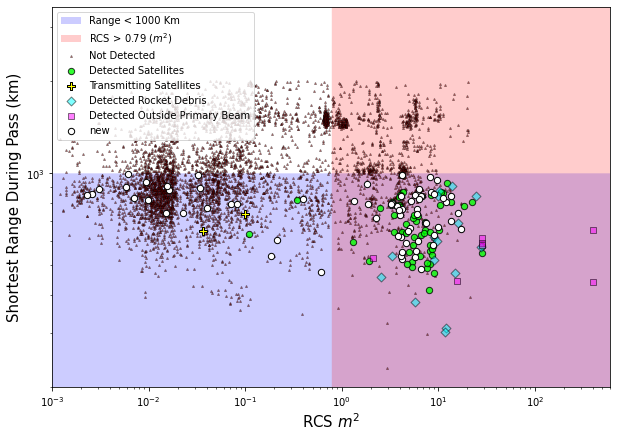

In [22]:

plt.figure(figsize=(10,7))
temp = np.linspace(0,1000, 1000)
temp2 = np.linspace(0.79,1000,1000)
hfont = {'fontname':'Helvetica', 'size':15}

plt.fill_between(temp, 0, 1000, facecolor='blue', alpha=0.2, label='Range < 1000 Km')
plt.fill_between(temp2,10000,0, facecolors='red', alpha=0.2,label='RCS > 0.79 $(m^{2})$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("RCS $m^2$", **hfont)
plt.ylabel("Shortest Range During Pass (km)", **hfont)
plt.ylim(200, 3500)
plt.xlim(0.001, 600)

color = "red"
plt.scatter(not_detected_rcs, not_detected_range,c=color,alpha=0.4,
                                marker="^",s=4,edgecolors='black',label="Not Detected")
color='lime'
plt.scatter(detected_rcs, detected_range,c=color,alpha=0.8,s=40,
                                edgecolors='black', label="Detected Satellites")

color='yellow'
plt.scatter(detected_transmitting_rcs, detected_transmitting_range,c=color,alpha=1 ,s=60, edgecolors='black', label="Transmitting Satellites", marker="P")

color='cyan'
plt.scatter(detected_rb_rcs, detected_rb_range,marker="D",
                                c=color,alpha=0.5,s=40,edgecolors='black',label="Detected Rocket Debris")

color='magenta'
plt.scatter(detected_outside_rcs, detected_outside_range,marker="s",
                                c=color,alpha=0.5,s=40,edgecolors='black',label="Detected Outside Primary Beam")

plt.scatter(new_rcs, np.array(new_range)/1000, label="new", c="white", marker="o",s=40, edgecolors="black")
plt.legend(loc=2)

In [26]:
obs_array = []
norad_array = []
detections_array = []
for i in range(42):
    i += 1
    with open("/media/steve/NewSSD/temp/outputSet{}.csv".format(i)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        for row in csv_reader:
            obs, norad, comment, dm, prevDetected = row
            if obs == "obsnum":
                continue
            if  comment == "detection":
                detections_array.append(obs)

In [27]:
print(len(detections_array))

115
